In [1]:
import multiprocessing
import threading
from time import time
import vio_ort
import vio_ort2
import json
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [2]:
odometry = vio_ort2.VIO(lat0=54.889668, lon0=83.1258973333, alt0=0)

# Путь к папке
#set_dir = '2025_1_16_15_43_35'
#set_dir = '2024_12_15_15_18_8_num_24'
set_dir = '2024_12_15_15_31_8_num_3'
#set_dir = '2024_12_15_15_31_8_num_5'

# Получение всех файлов с расширением .json
json_files = [f for f in os.listdir(set_dir) if f.endswith('.json')]

# Сортировка файлов по имени
json_files.sort()

# start_json = "1730798575417.json"
start = 30
count_json = 600

lat_VIO = []
lon_VIO = []

lat_GPS = []
lon_GPS = []

In [3]:
# Код с потоковой оптимизацией
def process_file_threaded(filename):
    with open(f'{set_dir}/{filename}', 'r') as file:
        data = json.load(file)
        if 'GNRMC' in data and data['GNRMC']['status'] == 'A':
            img_path = f'{set_dir}/{os.path.splitext(filename)[0]}.jpg'
            
            if not os.path.exists(img_path):
                return
            
            image = cv2.imread(img_path)
            if image is None:
                return
            
            try:
                result_vio = odometry.add_trace_pt(image, data)
                with threading.Lock():
                    lat_VIO.append(result_vio['lat'])
                    lon_VIO.append(result_vio['lon'])
                    lat_GPS.append(data['GNRMC']['lat'])
                    lon_GPS.append(data['GNRMC']['lon'])
                    # собираем время
                    elapsed_times.append(result_vio['elapsed_time'])
                    # собираем этапы
                    all_timings.append(result_vio['timings'])
            except Exception as e:
                print(f"Error processing {filename}: {e}")

# Запускаем обработку в потоках
threads = []
elapsed_times = []
all_timings = []
for filename in json_files[start:start + count_json]:
    thread = threading.Thread(target=process_file_threaded, args=(filename,))
    threads.append(thread)
    thread.start()

for thread in threads:
    thread.join()

In [4]:
print(f"Среднее время обработки одного файла: {np.mean(elapsed_times):.4f} секунд")
print(f"Максимальное время обработки: {np.max(elapsed_times):.4f} секунд")
print(f"Минимальное время обработки: {np.min(elapsed_times):.4f} секунд")

Среднее время обработки одного файла: 6.4594 секунд
Максимальное время обработки: 14.5540 секунд
Минимальное время обработки: 0.7203 секунд


In [5]:
# Анализ времени этапов
average_timings = {key: np.mean([t[key] for t in all_timings]) for key in all_timings[0].keys()}
print("Среднее время по этапам:")
for key, value in average_timings.items():
    print(f"{key}: {value:.10f} секунд")

Среднее время по этапам:
fetch_angles: 0.0000039554 секунд
fetch_height: 0.0000121611 секунд
preprocess_frame: 0.0131054395 секунд
rotation: 0.0323592478 секунд
fisheye_correction: 0.1781825257 секунд
detect_and_compute: 0.8303372748 секунд
local_position_calculation: 5.4053320616 секунд
velocity_calculation: 0.0000224019 секунд
GPS_calculation: 0.0000433532 секунд


In [6]:
print(f'GPS lat: {lat_GPS[0]}')
print(f'VIO lat: {lat_VIO[0]}')

GPS lat: 54.8894113333
VIO lat: 54.889668


In [7]:
print(f'GPS lon: {lon_GPS[0]}')
print(f'VIO lon: {lon_VIO[0]}')

GPS lon: 83.1257325
VIO lon: 83.1258973333


In [8]:
print(len(lat_GPS))
print(len(lat_VIO))

532
532


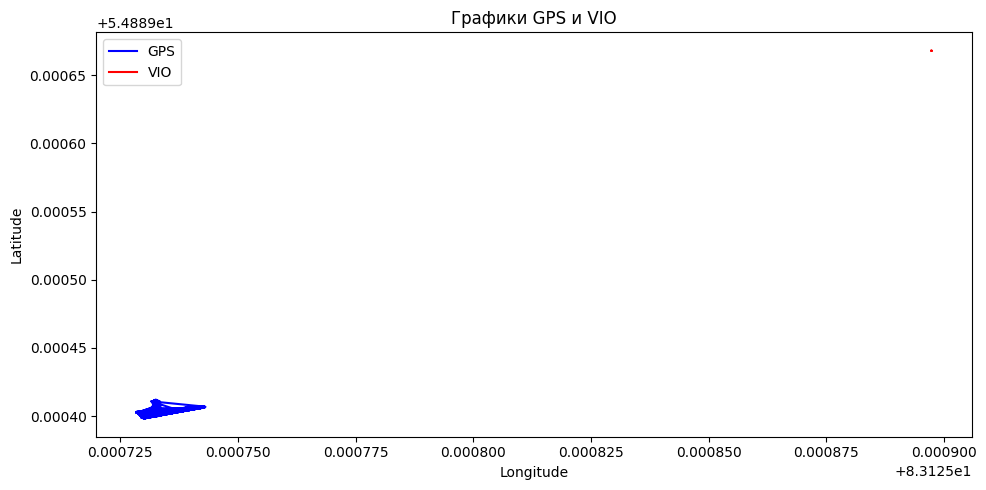

In [9]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

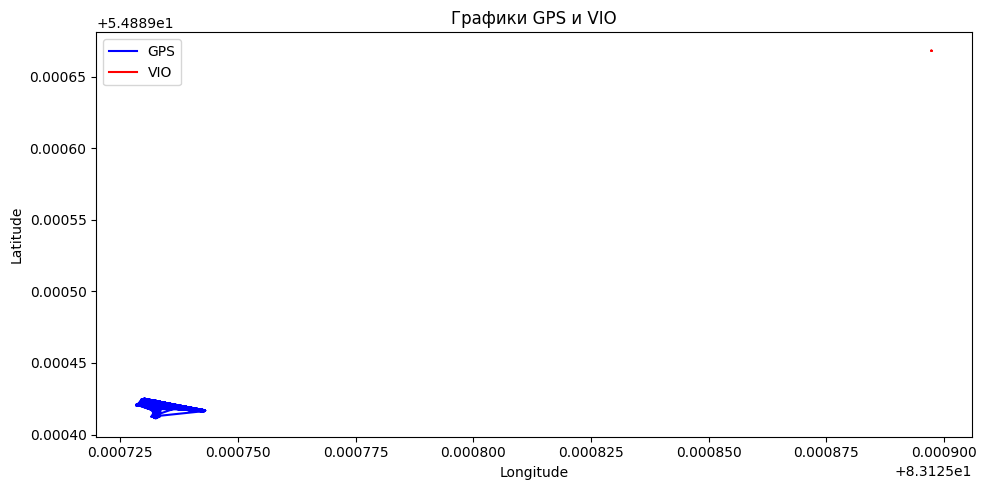

In [10]:
copy_lat_VIO = lat_VIO.copy()
copy_lon_VIO = lon_VIO.copy()

copy_lat_GPS = lat_GPS.copy()
copy_lon_GPS = lon_GPS.copy()

# Create figure and axis
# Создаем фигуру и оси
plt.figure(figsize=(10, 5))
# copy_lat_GPS = [ - x + 2 * 54.8894116667 for x in copy_lat_GPS]

# Рисуем первый график
plt.plot(copy_lon_GPS, copy_lat_GPS, label='GPS', color='blue')

# Рисуем второй график
plt.plot(copy_lon_VIO, copy_lat_VIO, label='VIO', color='red')

# Добавляем заголовок и метки осей
plt.title('Графики GPS и VIO')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Добавляем легенду
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()